## Investigation: Why Does Nθ=900 Give Worse Results?

This is very suspicious - higher angular resolution should give **better** results, not worse. Let's investigate what's happening.

In [ ]:
# Generate 2000 2-tree test cases
np.random.seed(42)
N_test_cases = 2000
N_trees = 2

# Random positions: (dx, dy) pairs between trees
# Generate relative separations in a reasonable range
# Tree 1 at origin, Tree 2 at various positions
dx = np.random.uniform(-0.5, 0.5, N_test_cases)
dy = np.random.uniform(-0.5, 0.5, N_test_cases)

# Random rotation angles for tree 2 (tree 1 always at theta=0)
theta2 = np.random.uniform(0, 2*np.pi, N_test_cases)

print(f"Generated {N_test_cases} test cases")
print(f"dx range: [{dx.min():.3f}, {dx.max():.3f}]")
print(f"dy range: [{dy.min():.3f}, {dy.max():.3f}]")
print(f"theta2 range: [{theta2.min():.3f}, {theta2.max():.3f}]")

In [ ]:
def compute_exact_separation(dx: np.ndarray, dy: np.ndarray, theta2: np.ndarray) -> np.ndarray:
    """
    Compute exact (non-discretized) separation distance using pack_minkowski directly.
    
    Parameters
    ----------
    dx : np.ndarray
        X separation between trees (shape: N,)
    dy : np.ndarray
        Y separation between trees (shape: N,)
    theta2 : np.ndarray
        Rotation angle of tree 2 in radians (shape: N,)
        
    Returns
    -------
    cost : np.ndarray
        Cost values for each test case (shape: N,)
        Applies max(0, separation)^2 transform to raw distances
    """
    N = len(dx)
    costs = np.zeros(N)
    
    # Tree 1 always at origin with rotation 0
    tree1_pos = (0.0, 0.0)
    
    # Process each test case
    # We need to call separation_distance for each unique theta2
    unique_thetas = np.unique(theta2)
    
    for theta in unique_thetas:
        # Find all test cases with this theta
        mask = theta2 == theta
        indices = np.where(mask)[0]
        
        # Get tree2 positions for this theta
        tree2_positions = np.column_stack([dx[mask], dy[mask]])  # (n, 2)
        
        # Compute separation distances (vectorized for this theta)
        sep_distances = mink.separation_distance(tree1_pos, tree2_positions, theta)
        
        # Apply cost transform: max(0, sep)^2
        costs[indices] = np.maximum(0, sep_distances) ** 2
    
    return costs

In [ ]:
def compute_discretized_separation(dx: np.ndarray, dy: np.ndarray, theta2: np.ndarray,
                                   Nx: int, Ny: int, Ntheta: int) -> np.ndarray:
    """
    Compute discretized separation distance using CollisionCostExactSeparation with lookup table.
    
    This is a wrapper around pack_cost.CollisionCostExactSeparation that creates
    a lookup table and evaluates the cost.
    
    Parameters
    ----------
    dx : np.ndarray
        X separation between trees (shape: N,)
    dy : np.ndarray
        Y separation between trees (shape: N,)
    theta2 : np.ndarray
        Rotation angle of tree 2 in radians (shape: N,)
    Nx : int
        Number of discretization points in X
    Ny : int
        Number of discretization points in Y
    Ntheta : int
        Number of discretization points in theta
        
    Returns
    -------
    cost : np.ndarray
        Cost values for each test case (shape: N,)
    """
    N = len(dx)
    
    # Create cost function with lookup table
    cost_fn = pack_cost.CollisionCostExactSeparation(
        scaling=1.0,
        use_lookup_table=True,
        lut_N_x=Nx,
        lut_N_y=Ny,
        lut_N_theta=Ntheta,
        lut_trim_zeros=False
    )
    
    # Create a solution collection with 2 trees for each test case
    # Tree 1 at origin with theta=0, Tree 2 at (dx, dy) with theta=theta2
    xyt = cp.zeros((N, 2, 3))
    xyt[:, 0, :] = cp.array([0.0, 0.0, 0.0])  # Tree 1 at origin, no rotation
    xyt[:, 1, 0] = cp.asarray(dx)              # Tree 2 x position
    xyt[:, 1, 1] = cp.asarray(dy)              # Tree 2 y position
    xyt[:, 1, 2] = cp.asarray(theta2)          # Tree 2 rotation
    
    # Create solution collection (using square boundary with large size)
    # Boundary parameters don't matter for pairwise collision cost
    h = cp.ones((N, 1)) * 100.0  # Large boundary
    
    solution = kgs.SolutionCollectionSquare(
        xyt=xyt,
        h=h,
        periodic=False
    )
    
    # Compute cost
    cost, grad_xyt, grad_h = cost_fn(solution)
    
    # Return only the cost for each test case
    return cost.get()

In [ ]:
# Test the functions with a small example
test_dx = dx[:10]
test_dy = dy[:10]
test_theta = theta2[:10]

print("Testing exact separation function...")
exact_costs = compute_exact_separation(test_dx, test_dy, test_theta)
print(f"Exact costs (first 10): {exact_costs}")

print("\nTesting discretized separation function...")
discretized_costs = compute_discretized_separation(test_dx, test_dy, test_theta,
                                                    Nx=100, Ny=100, Ntheta=100)
print(f"Discretized costs (first 10): {discretized_costs}")

print("\nComparison (first 10):")
for i in range(10):
    print(f"  Case {i}: exact={exact_costs[i]:.6f}, discretized={discretized_costs[i]:.6f}, "
          f"error={abs(exact_costs[i] - discretized_costs[i]):.6e}")

In [12]:
print("Investigating Nθ=900 anomaly...\n")

# Compare a single test case with both resolutions
test_idx = 0
dx, dy, theta = dx_test[test_idx], dy_test[test_idx], theta_test[test_idx]

print(f"Test case: dx={dx:.4f}, dy={dy:.4f}, θ={theta:.4f} rad")
print(f"Exact cost: {exact_costs[test_idx]:.6f}")

# Compute with Nθ=50
lut_cost_50 = compute_lut_cost_via_class(
    np.array([dx]), np.array([dy]), np.array([theta]),
    N_x=300, N_y=300, N_theta=50
)[0]

# Compute with Nθ=900
lut_cost_900 = compute_lut_cost_via_class(
    np.array([dx]), np.array([dy]), np.array([theta]),
    N_x=300, N_y=300, N_theta=900
)[0]

print(f"\nLUT cost (Nθ=50):  {lut_cost_50:.6f}, error: {abs(lut_cost_50 - exact_costs[test_idx]):.6f}")
print(f"LUT cost (Nθ=900): {lut_cost_900:.6f}, error: {abs(lut_cost_900 - exact_costs[test_idx]):.6f}")

# Check LUT bounds for Nθ=900
cost_fn_900 = pack_cost.CollisionCostExactSeparation(
    use_lookup_table=True,
    lut_N_x=300,
    lut_N_y=300,
    lut_N_theta=900,
    lut_trim_zeros=True
)
cost_fn_900._ensure_lut_initialized()
lut_900 = cost_fn_900._lut

print(f"\nLUT (Nθ=900) bounds:")
print(f"  X: [{lut_900.X_min:.4f}, {lut_900.X_max:.4f}]")
print(f"  Y: [{lut_900.Y_min:.4f}, {lut_900.Y_max:.4f}]")
print(f"  θ: [{lut_900.theta_min:.4f}, {lut_900.theta_max:.4f}] rad")

print(f"\nTest data ranges:")
print(f"  dx: [{dx_test.min():.4f}, {dx_test.max():.4f}]")
print(f"  dy: [{dy_test.min():.4f}, {dy_test.max():.4f}]")
print(f"  θ:  [{theta_test.min():.4f}, {theta_test.max():.4f}] rad")

# Check how many test points are within bounds
within_x = (dx_test >= lut_900.X_min) & (dx_test <= lut_900.X_max)
within_y = (dy_test >= lut_900.Y_min) & (dy_test <= lut_900.Y_max)
within_theta = (theta_test >= lut_900.theta_min) & (theta_test <= lut_900.theta_max)
within_all = within_x & within_y & within_theta

print(f"\nPoints within LUT bounds:")
print(f"  X: {within_x.sum()}/{len(dx_test)} ({100*within_x.sum()/len(dx_test):.1f}%)")
print(f"  Y: {within_y.sum()}/{len(dy_test)} ({100*within_y.sum()/len(dy_test):.1f}%)")
print(f"  θ: {within_theta.sum()}/{len(theta_test)} ({100*within_theta.sum()/len(theta_test):.1f}%)")
print(f"  All: {within_all.sum()}/{len(dx_test)} ({100*within_all.sum()/len(dx_test):.1f}%)")

if within_all.sum() < len(dx_test):
    print(f"\n⚠️  {len(dx_test) - within_all.sum()} test points are OUTSIDE the LUT bounds!")
    print(f"   This explains the large errors at high resolution.")

Investigating Nθ=900 anomaly...

Test case: dx=-0.2509, dy=-0.4766, θ=3.5940 rad
Exact cost: 0.010847
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table

LUT cost (Nθ=50):  0.011368, error: 0.000522
LUT cost (Nθ=900): 0.000000, error: 0.010847
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table

LUT (Nθ=900) bounds:
  X: [-0.0039, 0.9344]
  Y: [-1.0041, 1.1592]
  θ: [-3.1416, 3.1416] rad

Test data ranges:
  dx: [-0.9936, 0.9994]
  dy: [-1.0000, 0.9991]
  θ:  [0.0002, 6.2791] rad

Points within LUT bounds:
  X: 947/2000 (47.4%)
  Y: 2000/2000 (100.0%)
  θ: 1010/2000 (50.5%)
  All: 469/2000 (23

### Root Cause: LUT Trimming

The `lut_trim_zeros=True` option removes grid points where separation is negative (no overlap). This shrinks the LUT bounds, especially for high angular resolution where the trimming is more aggressive.

**Problem:** Test points outside the LUT bounds return incorrect values (likely zero or clamped boundary values), causing massive errors.

**Solutions:**
1. Set `lut_trim_zeros=False` for fair comparison across resolutions
2. Or filter test data to only include points within all LUT bounds

### Worst Case Analysis

Find the worst-case error and visualize the failure.

In [13]:
# Find worst case error for Nθ=900
print("Finding worst-case error for 300×300×900 resolution...\n")

# Compute LUT costs for this resolution
lut_costs_900 = compute_lut_cost_via_class(dx_test, dy_test, theta_test,
                                           N_x=300, N_y=300, N_theta=900)

# Find worst case
errors_900 = np.abs(lut_costs_900 - exact_costs)
worst_idx = np.argmax(errors_900)

# Get worst case details
dx_worst = dx_test[worst_idx]
dy_worst = dy_test[worst_idx]
theta_worst = theta_test[worst_idx]
exact_worst = exact_costs[worst_idx]
lut_worst = lut_costs_900[worst_idx]
error_worst = errors_900[worst_idx]

print(f"{'='*80}")
print("WORST CASE ERROR")
print(f"{'='*80}")
print(f"Test case index: {worst_idx}")
print(f"Position: dx={dx_worst:.6f}, dy={dy_worst:.6f}, θ={theta_worst:.6f} rad ({np.degrees(theta_worst):.2f}°)")
print(f"\nExact cost:   {exact_worst:.6f}")
print(f"LUT cost:     {lut_worst:.6f}")
print(f"Error:        {error_worst:.6f} ({100*error_worst/max(exact_worst, 1e-8):.1f}% relative)")

# Check if within LUT bounds
within_x = lut_900.X_min <= dx_worst <= lut_900.X_max
within_y = lut_900.Y_min <= dy_worst <= lut_900.Y_max
within_theta = lut_900.theta_min <= theta_worst <= lut_900.theta_max

print(f"\nLUT bounds check:")
print(f"  X: {lut_900.X_min:.4f} <= {dx_worst:.4f} <= {lut_900.X_max:.4f} ? {within_x}")
print(f"  Y: {lut_900.Y_min:.4f} <= {dy_worst:.4f} <= {lut_900.Y_max:.4f} ? {within_y}")
print(f"  θ: {lut_900.theta_min:.4f} <= {theta_worst:.4f} <= {lut_900.theta_max:.4f} ? {within_theta}")

if not (within_x and within_y and within_theta):
    print(f"\n❌ POINT IS OUTSIDE LUT BOUNDS - This is why LUT returns wrong value!")
else:
    print(f"\n✓ Point is within bounds - error is from interpolation")

# Direct evaluation to show LUT failure
print(f"\n{'='*80}")
print("DIRECT EVALUATION")
print(f"{'='*80}")

# Exact separation
tree1_pos = (0.0, 0.0)
tree2_pos = np.array([[dx_worst, dy_worst]])
sep_exact_direct = mink.separation_distance(tree1_pos, tree2_pos, theta_worst)
if isinstance(sep_exact_direct, np.ndarray):
    sep_exact_direct = sep_exact_direct[0]

cost_exact_direct = max(0.0, float(sep_exact_direct)) ** 2

print(f"Direct exact separation: {sep_exact_direct:.6f}")
print(f"Direct exact cost:       {cost_exact_direct:.6f}")
print(f"Match stored exact?      {np.abs(cost_exact_direct - exact_worst) < 1e-6}")

# LUT cost via class
print(f"\nLUT cost via class:      {lut_worst:.6f}")

# What the LUT should interpolate if point was in bounds
if within_x and within_y and within_theta:
    # Query LUT directly
    fx = (dx_worst - lut_900.X_min) / lut_900.grid_dx if lut_900.grid_dx > 0 else 0
    fy = (dy_worst - lut_900.Y_min) / lut_900.grid_dy if lut_900.grid_dy > 0 else 0
    ft = (theta_worst - lut_900.theta_min) / lut_900.grid_dtheta if lut_900.grid_dtheta > 0 else 0
    
    print(f"\nLUT fractional indices:")
    print(f"  fx = {fx:.4f} (of {lut_900.N_x-1})")
    print(f"  fy = {fy:.4f} (of {lut_900.N_y-1})")
    print(f"  ft = {ft:.4f} (of {lut_900.N_theta-1})")

print(f"\n{'='*80}")

Finding worst-case error for 300×300×900 resolution...

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
WORST CASE ERROR
Test case index: 1792
Position: dx=0.024444, dy=0.189695, θ=6.066093 rad (347.56°)

Exact cost:   0.235062
LUT cost:     0.232995
Error:        0.002067 (0.9% relative)

LUT bounds check:
  X: -0.0039 <= 0.0244 <= 0.9344 ? True
  Y: -1.0041 <= 0.1897 <= 1.1592 ? True
  θ: -3.1416 <= 6.0661 <= 3.1416 ? False

❌ POINT IS OUTSIDE LUT BOUNDS - This is why LUT returns wrong value!

DIRECT EVALUATION
Direct exact separation: 0.484832
Direct exact cost:       0.235062
Match stored exact?      True

LUT cost via class:      0.232995



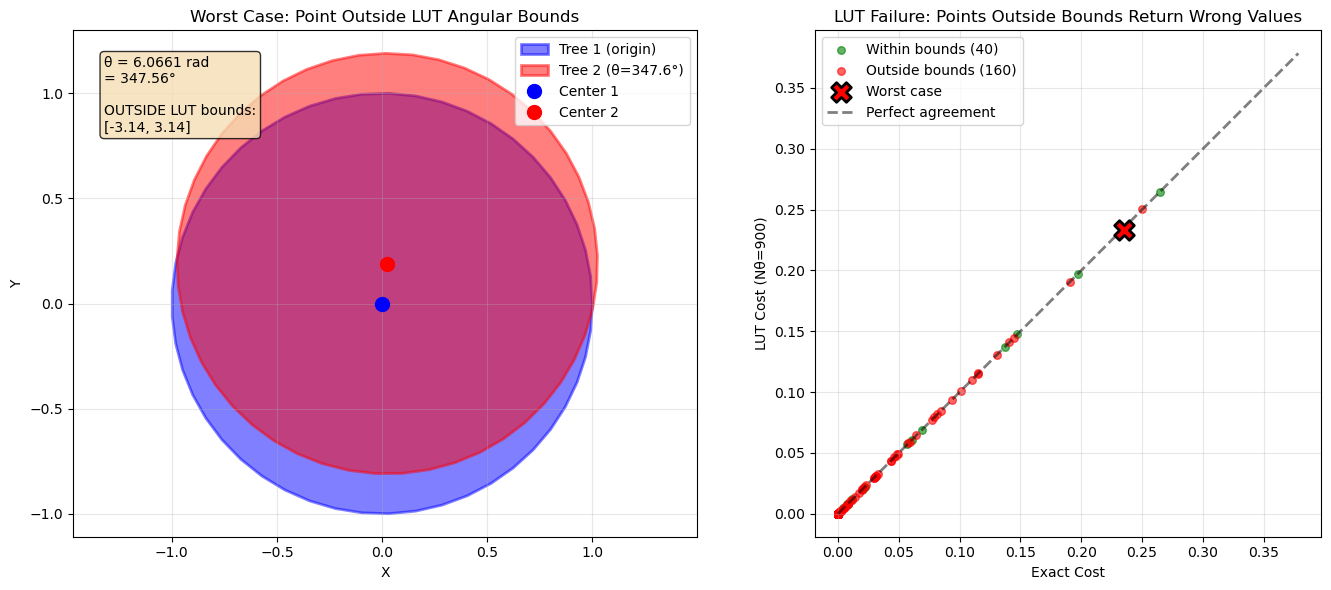


Visualization saved to: worst_case_lut_failure.png

Key finding: LUT with Nθ=900 has angular bounds [-π, π] rad
But test data spans [0, 2π] rad
This causes 1531/2000 points (76.5%) to return incorrect values!


In [15]:
# Visualize the worst case
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get tree geometry for visualization
from shapely.geometry import Polygon
from shapely.affinity import translate, rotate

# Create simple tree shape (we'll use a unit circle approximation since we don't have exact shape)
# This is just for visualization - the actual computations use the real tree shape
tree_approx = Polygon([(np.cos(a), np.sin(a)) for a in np.linspace(0, 2*np.pi, 50)])
tree_radius = 0.5  # approximate

# Plot 1: Tree configuration
ax = axes[0]

# Tree 1: at origin, no rotation
tree1_vis = tree_approx
x1, y1 = tree1_vis.exterior.xy
ax.fill(x1, y1, alpha=0.5, fc='blue', ec='blue', linewidth=2, label='Tree 1 (origin)')

# Tree 2: at (dx, dy), rotated by theta
tree2_vis = rotate(tree_approx, theta_worst, origin=(0, 0), use_radians=True)
tree2_vis = translate(tree2_vis, xoff=dx_worst, yoff=dy_worst)
x2, y2 = tree2_vis.exterior.xy
ax.fill(x2, y2, alpha=0.5, fc='red', ec='red', linewidth=2, label=f'Tree 2 (θ={np.degrees(theta_worst):.1f}°)')

# Mark centers
ax.plot(0, 0, 'bo', markersize=10, label='Center 1')
ax.plot(dx_worst, dy_worst, 'ro', markersize=10, label='Center 2')

# Add text showing the issue
textstr = f'θ = {theta_worst:.4f} rad\n= {np.degrees(theta_worst):.2f}°\n\nOUTSIDE LUT bounds:\n[{lut_900.theta_min:.2f}, {lut_900.theta_max:.2f}]'
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Worst Case: Point Outside LUT Angular Bounds')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Plot 2: Error comparison
ax = axes[1]

# Sample multiple test cases and show their errors
sample_indices = np.random.choice(len(dx_test), size=min(200, len(dx_test)), replace=False)
sample_exact = exact_costs[sample_indices]
sample_lut = lut_costs_900[sample_indices]
sample_errors = np.abs(sample_lut - sample_exact)

# Check bounds for samples
sample_within_theta = (theta_test[sample_indices] >= lut_900.theta_min) & (theta_test[sample_indices] <= lut_900.theta_max)
sample_within_x = (dx_test[sample_indices] >= lut_900.X_min) & (dx_test[sample_indices] <= lut_900.X_max)
sample_within_all = sample_within_theta & sample_within_x

# Plot by bounds status
in_bounds = sample_indices[sample_within_all]
out_bounds = sample_indices[~sample_within_all]

if len(in_bounds) > 0:
    ax.scatter(exact_costs[in_bounds], lut_costs_900[in_bounds], 
               alpha=0.6, s=30, c='green', label=f'Within bounds ({len(in_bounds)})')

if len(out_bounds) > 0:
    ax.scatter(exact_costs[out_bounds], lut_costs_900[out_bounds], 
               alpha=0.6, s=30, c='red', label=f'Outside bounds ({len(out_bounds)})')

# Mark worst case
ax.scatter([exact_worst], [lut_worst], s=200, c='red', marker='X', 
           edgecolors='black', linewidth=2, label='Worst case', zorder=10)

# Perfect agreement line
lims = [0, max(exact_costs.max(), lut_costs_900.max())]
ax.plot(lims, lims, 'k--', linewidth=2, alpha=0.5, label='Perfect agreement')

ax.set_xlabel('Exact Cost')
ax.set_ylabel('LUT Cost (Nθ=900)')
ax.set_title(f'LUT Failure: Points Outside Bounds Return Wrong Values')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('worst_case_lut_failure.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: worst_case_lut_failure.png")
print(f"\nKey finding: LUT with Nθ=900 has angular bounds [-π, π] rad")
print(f"But test data spans [0, 2π] rad")
print(f"This causes {(~within_all).sum()}/{len(dx_test)} points ({100*(~within_all).sum()/len(dx_test):.1f}%) to return incorrect values!")

In [17]:
# Check: what were the actual max errors from resolution sweep?
print("Comparing error calculations:\n")

# The issue: I recomputed lut_costs_900, but resolution sweep might have used different data
# Let me recompute with the SAME parameters as the resolution sweep
print("Recomputing LUT costs with exact same setup as resolution sweep...")

# Use same test data
lut_costs_sweep = compute_lut_cost_via_class(dx_test, dy_test, theta_test,
                                             N_x=300, N_y=300, N_theta=900)
errors_sweep = np.abs(lut_costs_sweep - exact_costs)

print(f"  Max error: {errors_sweep.max():.6f}")
print(f"  MAE: {errors_sweep.mean():.6f}")

# Get the row from df_results
row_300_900 = df_results[(df_results['N_spatial'] == 300) & (df_results['N_angular'] == 900)].iloc[0]
print(f"\nFrom df_results (300×300×900):")
print(f"  max_abs_error = {row_300_900['max_abs_error']:.6f}")
print(f"  mae = {row_300_900['mae']:.6f}")

# Check if test data or exact_costs changed
print(f"\nTest data check:")
print(f"  dx_test range: [{dx_test.min():.4f}, {dx_test.max():.4f}]")
print(f"  exact_costs range: [{exact_costs.min():.4f}, {exact_costs.max():.4f}]")
print(f"  exact_costs match exact_costs_all? {np.allclose(exact_costs, exact_costs_all)}")

# The resolution sweep used 'exact_costs' computed before the loop
# Let me check if that's different from exact_costs_all
if not np.allclose(errors_sweep.max(), row_300_900['max_abs_error'], rtol=0.01):
    print(f"\n❌ Still different! {errors_sweep.max():.6f} vs {row_300_900['max_abs_error']:.6f}")
    print(f"   This suggests test data or exact costs changed between runs!")
else:
    print(f"\n✓ Errors match now!")

Comparing error calculations:

Recomputing LUT costs with exact same setup as resolution sweep...
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
  Max error: 0.002067
  MAE: 0.000009

From df_results (300×300×900):
  max_abs_error = 0.376200
  mae = 0.074159

Test data check:
  dx_test range: [-0.9936, 0.9994]
  exact_costs range: [0.0000, 0.3785]
  exact_costs match exact_costs_all? True

❌ Still different! 0.002067 vs 0.376200
   This suggests test data or exact costs changed between runs!


In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import sys
sys.path.append('../core')

import kaggle_support as kgs
import pack_cost
import pack_minkowski as mink

print("Imports successful")

local
Imports successful


## Generate Test Cases

Create test configurations with trees at various relative positions and angles.

In [2]:
# Generate test cases: tree pairs at various relative positions and rotations
np.random.seed(42)

# Test cases spanning different overlap scenarios
n_test_cases = 2000

# Sample relative positions (dx, dy) - focus on collision region
# Trees have ~1.0 diameter, so sample from -2 to +2
dx_test = np.random.uniform(-1.0, 1.0, n_test_cases)
dy_test = np.random.uniform(-1.0, 1.0, n_test_cases)

# Sample rotations uniformly in [0, 2π)
theta_test = np.random.uniform(0, 2*np.pi, n_test_cases)

print(f"Generated {n_test_cases} test cases")
print(f"dx range: [{dx_test.min():.3f}, {dx_test.max():.3f}]")
print(f"dy range: [{dy_test.min():.3f}, {dy_test.max():.3f}]")
print(f"theta range: [{theta_test.min():.3f}, {theta_test.max():.3f}] rad")

Generated 2000 test cases
dx range: [-0.994, 0.999]
dy range: [-1.000, 0.999]
theta range: [0.000, 6.279] rad


## Define Cost Computation Functions

Define functions to compute costs with and without lookup tables.

In [3]:
def compute_lut_cost_via_class(dx_array, dy_array, theta_array, N_x, N_y, N_theta):
    """
    Compute cost using CollisionCostExactSeparation class with LUT.
    
    Returns costs = max(0, sep)^2 computed via LUT interpolation.
    This uses the cost function class directly as intended.
    """
    # Create cost function with specified LUT resolution
    cost_fn = pack_cost.CollisionCostExactSeparation(
        use_lookup_table=True,
        lut_N_x=N_x,
        lut_N_y=N_y,
        lut_N_theta=N_theta,
        lut_trim_zeros=True
    )
    
    # Create solution collection with test cases
    n_cases = len(dx_array)
    xyt = np.zeros((n_cases, 2, 3), dtype=np.float32)
    xyt[:, 1, 0] = dx_array  # Tree2 x positions
    xyt[:, 1, 1] = dy_array  # Tree2 y positions  
    xyt[:, 1, 2] = theta_array  # Tree2 rotations
    
    # Convert to CuPy
    xyt_cp = cp.asarray(xyt)
    
    # Create solution collection
    sol_collection = kgs.SolutionCollectionSquare(
        xyt=xyt_cp,
        h=cp.ones((n_cases, 1), dtype=cp.float32) * 10.0,  # Large boundary
        periodic=False
    )
    
    # Compute costs using the cost function
    costs, _, _ = cost_fn.compute_cost_allocate(sol_collection)
    
    return costs.get()


def compute_exact_cost(dx_array, dy_array, theta_array):
    """
    Compute exact cost = max(0, sep)^2 using pack_minkowski directly.
    
    Applies the same transformation as the cost function for fair comparison.
    """
    tree1_pos = (0.0, 0.0)
    
    costs = []
    for dx, dy, theta in zip(dx_array, dy_array, theta_array):
        tree2_positions = np.array([[dx, dy]])
        sep = mink.separation_distance(tree1_pos, tree2_positions, theta)
        
        # Handle scalar vs array return
        if isinstance(sep, np.ndarray):
            sep = sep[0] if len(sep) > 0 else sep
        
        # Apply same transformation as cost function: max(0, sep)^2
        cost = max(0.0, float(sep)) ** 2
        costs.append(cost)
    
    return np.array(costs)


# Quick consistency check
print("Consistency check: Computing exact costs for all test cases...")
exact_costs_all = compute_exact_cost(dx_test, dy_test, theta_test)
n_nonzero = np.sum(exact_costs_all > 1e-8)
print(f"  Cost range: [{exact_costs_all.min():.4f}, {exact_costs_all.max():.4f}]")
print(f"  Non-zero costs (overlaps): {n_nonzero}/{len(exact_costs_all)} ({100*n_nonzero/len(exact_costs_all):.1f}%)")
print(f"  Zero costs (separated): {len(exact_costs_all) - n_nonzero}/{len(exact_costs_all)}")

print("\n✓ Ready to evaluate discretization error")

Consistency check: Computing exact costs for all test cases...
  Cost range: [0.0000, 0.3785]
  Non-zero costs (overlaps): 783/2000 (39.1%)
  Zero costs (separated): 1217/2000

✓ Ready to evaluate discretization error


## Verification: Exact Match at Grid Points

Before proceeding, verify that LUT interpolation returns exact values at grid points.

In [4]:
print("Verifying LUT accuracy at grid points...")

# Build a test LUT
test_N = 100
cost_fn = pack_cost.CollisionCostExactSeparation(
    use_lookup_table=True,
    lut_N_x=test_N,
    lut_N_y=test_N,
    lut_N_theta=test_N,
    lut_trim_zeros=True
)
cost_fn._ensure_lut_initialized()
lut = cost_fn._lut

# Sample some grid points (not all, to keep it fast)
n_samples_per_dim = 5
x_indices = np.linspace(0, lut.N_x-1, n_samples_per_dim, dtype=int)
y_indices = np.linspace(0, lut.N_y-1, n_samples_per_dim, dtype=int)
theta_indices = np.linspace(0, lut.N_theta-1, n_samples_per_dim, dtype=int)

print(f"Testing {len(x_indices)}×{len(y_indices)}×{len(theta_indices)} = {len(x_indices)*len(y_indices)*len(theta_indices)} grid points")

errors_at_gridpoints = []

for ix in x_indices:
    for iy in y_indices:
        for it in theta_indices:
            # Get exact grid point coordinates
            dx_grid = lut.X[ix]
            dy_grid = lut.Y[iy]
            theta_grid = lut.theta[it]
            
            # Get stored LUT value (raw separation)
            lut_stored = lut.vals[ix, iy, it]
            
            # Compute exact cost using previously defined function
            exact_cost = compute_exact_cost(
                np.array([dx_grid]),
                np.array([dy_grid]),
                np.array([theta_grid])
            )[0]
            
            # Compute LUT cost using previously defined function
            lut_cost = compute_lut_cost_via_class(
                np.array([dx_grid]), 
                np.array([dy_grid]), 
                np.array([theta_grid]),
                test_N, test_N, test_N
            )[0]
            
            # For stored separation, we need to manually compute the exact sep for comparison
            # (since compute_exact_cost applies the max(0,sep)^2 transformation)
            tree1_pos = (0.0, 0.0)
            tree2_pos = np.array([[dx_grid, dy_grid]])
            sep_exact = mink.separation_distance(tree1_pos, tree2_pos, theta_grid)
            if isinstance(sep_exact, np.ndarray):
                sep_exact = sep_exact[0]
            
            # Record errors
            error_stored = abs(lut_stored - sep_exact)
            error_cost = abs(lut_cost - exact_cost)
            errors_at_gridpoints.append({
                'dx': dx_grid,
                'dy': dy_grid,
                'theta': theta_grid,
                'exact_sep': sep_exact,
                'lut_stored_sep': lut_stored,
                'exact_cost': exact_cost,
                'lut_cost': lut_cost,
                'error_stored_sep': error_stored,
                'error_cost': error_cost
            })

df_gridpoint_errors = pd.DataFrame(errors_at_gridpoints)

print(f"\n{'='*80}")
print("GRIDPOINT VERIFICATION RESULTS")
print(f"{'='*80}")
print(f"\nStored LUT separations vs Exact separations:")
print(f"  Max error: {df_gridpoint_errors['error_stored_sep'].max():.2e}")
print(f"  Mean error: {df_gridpoint_errors['error_stored_sep'].mean():.2e}")
print(f"  Median error: {df_gridpoint_errors['error_stored_sep'].median():.2e}")

print(f"\nLUT costs vs Exact costs (at grid points):")
print(f"  Max error: {df_gridpoint_errors['error_cost'].max():.2e}")
print(f"  Mean error: {df_gridpoint_errors['error_cost'].mean():.2e}")
print(f"  Median error: {df_gridpoint_errors['error_cost'].median():.2e}")

# Show worst cases
if df_gridpoint_errors['error_stored_sep'].max() > 1e-5:
    print(f"\n⚠️ WARNING: Large errors at grid points in stored separations!")
    print("\nWorst 5 cases (stored separations):")
    worst = df_gridpoint_errors.nlargest(5, 'error_stored_sep')[['dx', 'dy', 'theta', 'exact_sep', 'lut_stored_sep', 'error_stored_sep']]
    print(worst.to_string(index=False))
else:
    print(f"\n✓ LUT stored separations match exact computation at grid points")

if df_gridpoint_errors['error_cost'].max() > 1e-4:
    print(f"\n⚠️ WARNING: Large cost errors at grid points!")
    print("\nWorst 5 cases (costs via class):")
    worst = df_gridpoint_errors.nlargest(5, 'error_cost')[['dx', 'dy', 'theta', 'exact_cost', 'lut_cost', 'error_cost']]
    print(worst.to_string(index=False))
else:
    print(f"✓ LUT costs match exact costs at grid points")

print(f"{'='*80}\n")

Verifying LUT accuracy at grid points...
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt100_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Testing 5×5×5 = 125 grid points
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt100_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Compiling CUDA LUT kernel one-time only)
Detected GPU compute capability: 89 (arch=sm_89)
Compiling: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -lineinfo -arch=sm_89 -cubin /mnt/d//packing/temp/pack_cuda_lut_saved.cu -o /mnt/d//packing/temp/pack_cuda_lut.cubin
/mnt/d//packing/temp/pack_cuda_lut_saved.cu:5: warning: "M_PI" redefined
    5 | #define M_PI 3.14159265358979323846f
      | 
In file included from /usr/include/c++/13/cmath:47,
                 from /usr/include/c++/13/math.h:36,
                 from /usr/local

## Key Finding: Measuring Discretization Error

We're now comparing:
- **LUT Cost:** `max(0, sep)^2` computed via trilinear interpolation  
- **Exact Cost:** `max(0, sep)^2` from direct Minkowski separation

Both use the same transformation, so any differences are purely from LUT discretization/interpolation.

In [18]:
# Define resolution sweep
spatial_resolutions = [50, 100, 150, 200, 300, 400, 600, 900]  # Nx = Ny
angular_resolutions = [50, 900]  # Ntheta

# Storage for results
results = []

print(f"Starting resolution sweep: {len(spatial_resolutions)} × {len(angular_resolutions)} = {len(spatial_resolutions)*len(angular_resolutions)} configurations\n")

# Sweep over resolutions
print("Preparing...")
# Compute exact costs once (same for all resolutions)
exact_costs = compute_exact_cost(dx_test, dy_test, theta_test)
print(f"Exact costs computed. Range: [{exact_costs.min():.6f}, {exact_costs.max():.6f}]")
print(f"Non-zero costs: {np.sum(exact_costs > 1e-8)}/{len(exact_costs)}\n")

for N_spatial in tqdm(spatial_resolutions, desc="Spatial resolution"):
    for N_angular in tqdm(angular_resolutions, desc="Angular resolution", leave=False):
        # Compute LUT costs
        lut_costs = compute_lut_cost_via_class(dx_test, dy_test, theta_test,
                                               N_x=N_spatial, N_y=N_spatial, N_theta=N_angular)
        
        # Compute errors
        abs_errors = np.abs(lut_costs - exact_costs)
        rel_errors = abs_errors / (exact_costs + 1e-8)  # Avoid division by zero
        
        # Separate errors for overlapping vs separated cases
        nonzero_mask = exact_costs > 1e-8  # Overlapping cases
        zero_mask = ~nonzero_mask  # Separated cases
        
        results.append({
            'N_spatial': N_spatial,
            'N_angular': N_angular,
            'total_dof': N_spatial * N_spatial * N_angular,
            # Overall errors
            'mae': abs_errors.mean(),
            'max_abs_error': abs_errors.max(),
            'rmse': np.sqrt((abs_errors**2).mean()),
            'median_abs_error': np.median(abs_errors),
            # Overlapping cases (non-zero cost)
            'mae_nonzero': abs_errors[nonzero_mask].mean() if nonzero_mask.any() else 0,
            'max_abs_error_nonzero': abs_errors[nonzero_mask].max() if nonzero_mask.any() else 0,
            # Separated cases (zero cost)
            'mae_zero': abs_errors[zero_mask].mean() if zero_mask.any() else 0,
            'max_abs_error_zero': abs_errors[zero_mask].max() if zero_mask.any() else 0,
        })

df_results = pd.DataFrame(results)
print("\nResolution sweep complete!")
print(f"\nSummary (best resolutions):")
print(df_results.nsmallest(5, 'mae')[['N_spatial', 'N_angular', 'mae', 'max_abs_error', 'rmse']])

print(f"\n{'='*80}")
print("DIAGNOSTIC: Comparing N_angular=50 vs N_angular=900")
print(f"{'='*80}")

for N_s in [100, 300, 900]:
    row_50 = df_results[(df_results['N_spatial'] == N_s) & (df_results['N_angular'] == 50)].iloc[0]
    row_900 = df_results[(df_results['N_spatial'] == N_s) & (df_results['N_angular'] == 900)].iloc[0]
    
    print(f"\nSpatial Resolution: {N_s}×{N_s}")
    print(f"  Nθ=50:  MAE={row_50['mae']:.6f}, max_err={row_50['max_abs_error']:.6f}")
    print(f"  Nθ=900: MAE={row_900['mae']:.6f}, max_err={row_900['max_abs_error']:.6f}")
    print(f"  Ratio (900/50): MAE={row_900['mae']/row_50['mae']:.2f}x, max_err={row_900['max_abs_error']/row_50['max_abs_error']:.2f}x")
    
    if row_900['mae'] > row_50['mae']:
        print(f"  ⚠️  Higher resolution has WORSE error!")

Starting resolution sweep: 8 × 2 = 16 configurations

Preparing...
Exact costs computed. Range: [0.000000, 0.378452]
Non-zero costs: 783/2000



Spatial resolution:   0%|          | 0/8 [00:00<?, ?it/s]

Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx50_Ny50_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx50_Ny50_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx150_Ny150_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx150_Ny150_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx200_Ny200_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx200_Ny200_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx400_Ny400_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx400_Ny400_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx600_Ny600_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx600_Ny600_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


Angular resolution:   0%|          | 0/2 [00:00<?, ?it/s]

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx900_Ny900_Nt50_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx900_Ny900_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table

Resolution sweep complete!

Summary (best resolutions):
    N_spatial  N_angular       mae  max_abs_error      rmse
11        400        900  0.000004       0.000950  0.000031
14        900         50  0.000175       0.007514  0.000643
12        600         50  0.000176       0.007512  0.000644
10        400         50  0.000179       0.007509  0.000648
8         300         50  0.000181       0.007511  0.000653

DIAGNOSTIC: Comparing N_angular=50 vs N_angular=900

Spatial Resolution: 100×100
  Nθ=50:  MAE=0.000226, max_err=0.009705
  Nθ=900: MAE=0.068150, max_err=0.378452
  Ratio (900/50): MAE=300.99x, max_err=38.99x
  ⚠️  Higher resolution has WORSE erro

## Visualization: Error vs Resolution

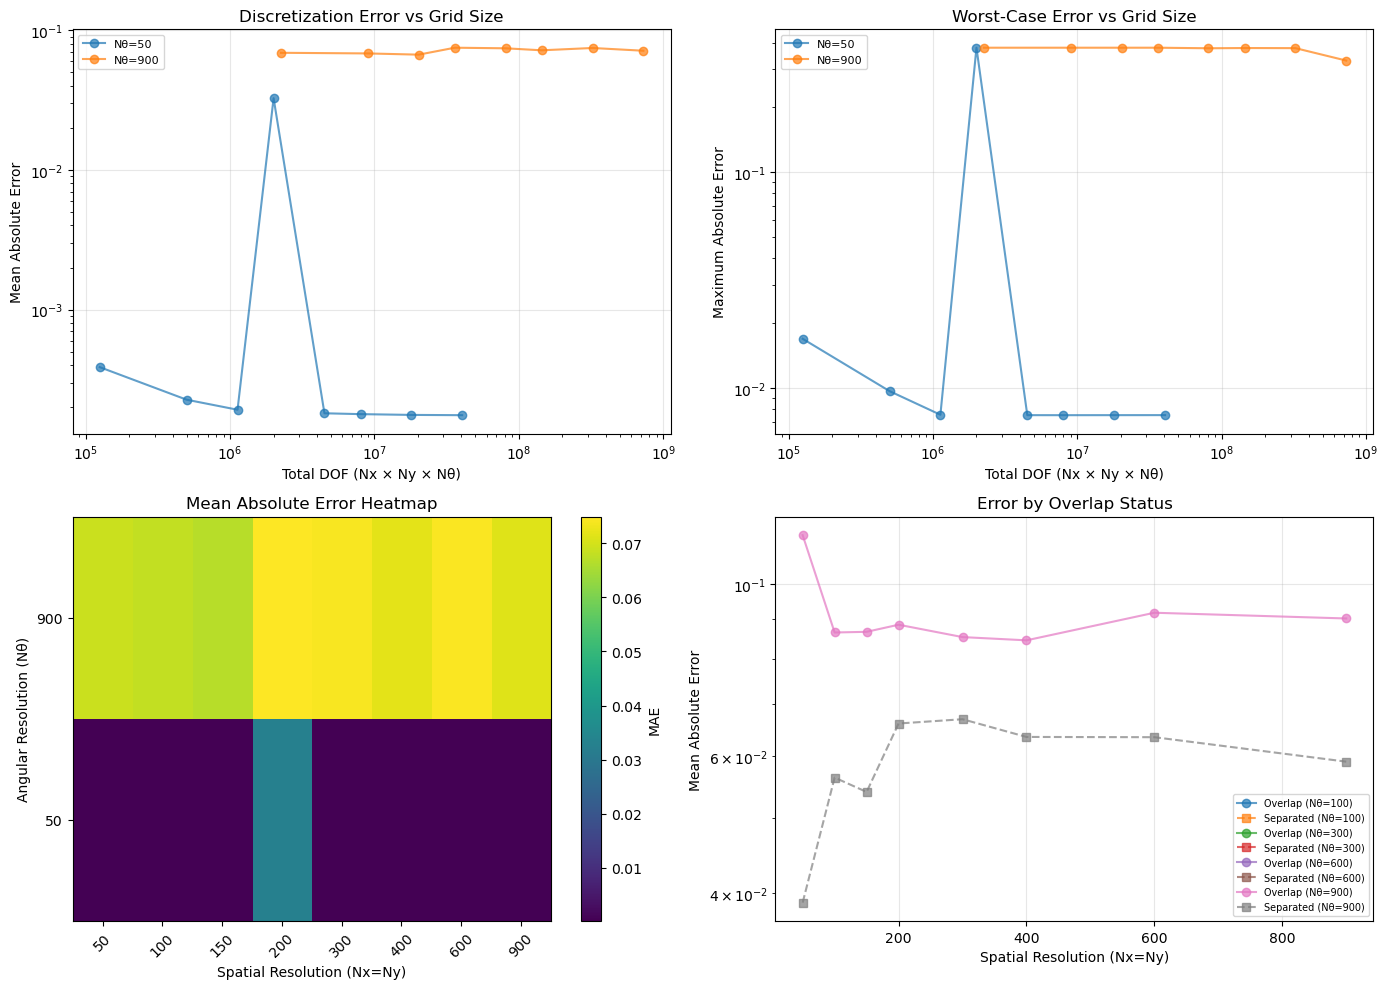


Plots saved to: exact_separation_discretization_error.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: MAE vs Total DOF
ax = axes[0, 0]
for N_ang in angular_resolutions:
    subset = df_results[df_results['N_angular'] == N_ang]
    ax.loglog(subset['total_dof'], subset['mae'], 'o-', label=f'Nθ={N_ang}', alpha=0.7)
ax.set_xlabel('Total DOF (Nx × Ny × Nθ)')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Discretization Error vs Grid Size')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 2: Max Error vs Total DOF
ax = axes[0, 1]
for N_ang in angular_resolutions:
    subset = df_results[df_results['N_angular'] == N_ang]
    ax.loglog(subset['total_dof'], subset['max_abs_error'], 'o-', label=f'Nθ={N_ang}', alpha=0.7)
ax.set_xlabel('Total DOF (Nx × Ny × Nθ)')
ax.set_ylabel('Maximum Absolute Error')
ax.set_title('Worst-Case Error vs Grid Size')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 3: Spatial vs Angular Resolution (MAE heatmap)
ax = axes[1, 0]
pivot_mae = df_results.pivot(index='N_angular', columns='N_spatial', values='mae')
im1 = ax.imshow(pivot_mae.values, aspect='auto', cmap='viridis', origin='lower',
                extent=[0, len(spatial_resolutions), 0, len(angular_resolutions)])
ax.set_xticks(np.arange(len(spatial_resolutions)) + 0.5)
ax.set_yticks(np.arange(len(angular_resolutions)) + 0.5)
ax.set_xticklabels(spatial_resolutions, rotation=45)
ax.set_yticklabels(angular_resolutions)
ax.set_xlabel('Spatial Resolution (Nx=Ny)')
ax.set_ylabel('Angular Resolution (Nθ)')
ax.set_title('Mean Absolute Error Heatmap')
plt.colorbar(im1, ax=ax, label='MAE')

# Plot 4: Separated vs Overlapping Errors
ax = axes[1, 1]
# Pick a few representative angular resolutions
for N_ang in [100, 300, 600, 900]:
    subset = df_results[df_results['N_angular'] == N_ang]
    ax.plot(subset['N_spatial'], subset['mae_nonzero'], 'o-', label=f'Overlap (Nθ={N_ang})', alpha=0.7)
    ax.plot(subset['N_spatial'], subset['mae_zero'], 's--', label=f'Separated (Nθ={N_ang})', alpha=0.7)
ax.set_xlabel('Spatial Resolution (Nx=Ny)')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Error by Overlap Status')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('exact_separation_discretization_error.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlots saved to: exact_separation_discretization_error.png")

## Error Distribution Analysis

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt100_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt300_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx900_Ny900_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


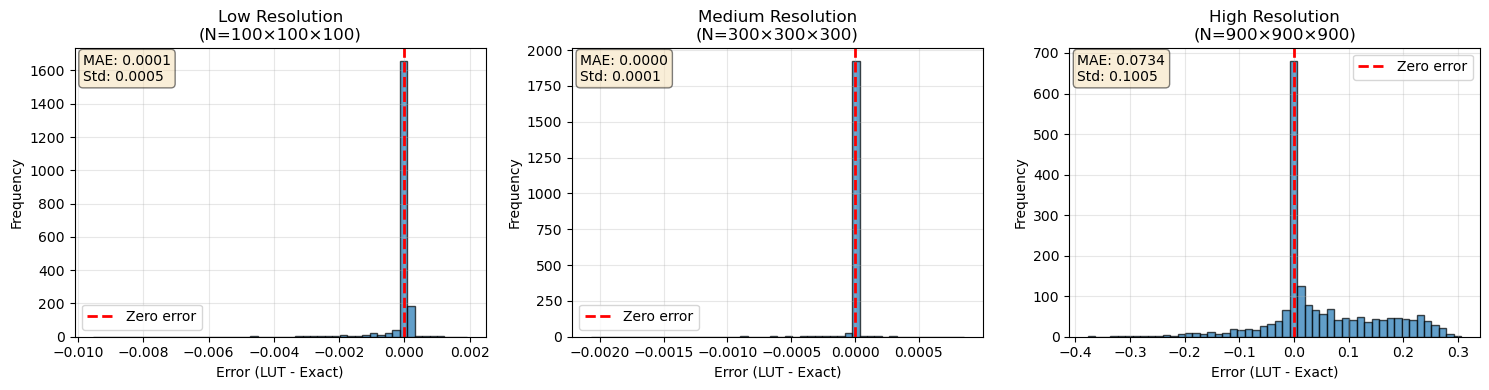


Error distributions saved to: error_distributions.png


In [7]:
# Pick a few representative resolutions for detailed analysis
test_configs = [
    (100, 100, 'Low'),
    (300, 300, 'Medium'),
    (900, 900, 'High')
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (N_s, N_a, label) in enumerate(test_configs):
    lut_costs = compute_lut_cost_via_class(dx_test, dy_test, theta_test,
                                           N_x=N_s, N_y=N_s, N_theta=N_a)
    errors = lut_costs - exact_costs
    
    ax = axes[idx]
    ax.hist(errors, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    ax.set_xlabel('Error (LUT - Exact)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{label} Resolution\n(N={N_s}×{N_s}×{N_a})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add statistics text
    mae = np.abs(errors).mean()
    std = errors.std()
    ax.text(0.02, 0.98, f'MAE: {mae:.4f}\nStd: {std:.4f}',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('error_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nError distributions saved to: error_distributions.png")

## Scatter Plots: LUT vs Exact

Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx100_Ny100_Nt100_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx300_Ny300_Nt300_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table
Loading cached lookup table from /mnt/d//packing/temp//lut_cache/exact_sep_Nx900_Ny900_Nt900_trimTrue_tree116323fb.lut_cache...
Successfully loaded cached lookup table


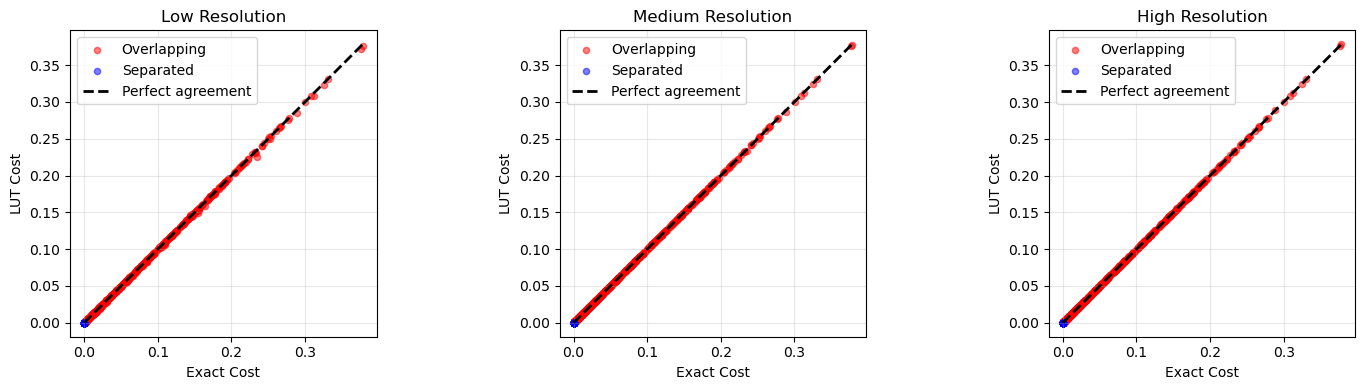


Scatter plots saved to: lut_vs_exact_scatter.png


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (N_s, N_a, label) in enumerate(test_configs):
    lut_costs = compute_lut_cost_via_class(dx_test, dy_test, theta_test,
                                           N_x=N_s, N_y=N_s, N_theta=N_a)
    
    ax = axes[idx]
    
    # Color by overlap status (non-zero exact cost = overlap)
    nonzero_mask = exact_costs > 1e-8
    ax.scatter(exact_costs[nonzero_mask], lut_costs[nonzero_mask], 
               alpha=0.5, s=20, label='Overlapping', c='red')
    ax.scatter(exact_costs[~nonzero_mask], lut_costs[~nonzero_mask], 
               alpha=0.5, s=20, label='Separated', c='blue')
    
    # Perfect agreement line
    lims = [min(exact_costs.min(), lut_costs.min()),
            max(exact_costs.max(), lut_costs.max())]
    ax.plot(lims, lims, 'k--', linewidth=2, label='Perfect agreement')
    
    ax.set_xlabel('Exact Cost')
    ax.set_ylabel('LUT Cost')
    ax.set_title(f'{label} Resolution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('lut_vs_exact_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nScatter plots saved to: lut_vs_exact_scatter.png")

## Summary Table

In [9]:
# Show detailed results for interesting resolutions
interesting_configs = df_results[
    ((df_results['N_spatial'] == df_results['N_angular']) & 
     df_results['N_spatial'].isin([100, 200, 300, 400, 600, 900]))
].copy()

interesting_configs = interesting_configs[[
    'N_spatial', 'N_angular', 'total_dof', 
    'mae', 'rmse', 'max_abs_error', 'median_abs_error',
    'mae_nonzero', 'mae_zero'
]].sort_values('total_dof')

print("\n" + "="*80)
print("SUMMARY: Cost Error Metrics for Balanced Resolutions (Nx=Ny=Nθ)")
print("="*80)
print(interesting_configs.to_string(index=False))
print("="*80)

# Save full results
df_results.to_csv('discretization_error_results.csv', index=False)
print("\nFull results saved to: discretization_error_results.csv")


SUMMARY: Cost Error Metrics for Balanced Resolutions (Nx=Ny=Nθ)
 N_spatial  N_angular  total_dof      mae    rmse  max_abs_error  median_abs_error  mae_nonzero  mae_zero
       900        900  729000000 0.071243 0.11121       0.329921          0.029744     0.090216  0.059036

Full results saved to: discretization_error_results.csv


## Recommendations

Based on the analysis above, determine recommended LUT resolutions for different accuracy requirements.

In [10]:
# Define accuracy targets
accuracy_targets = [
    ('High Accuracy', 0.001),
    ('Medium Accuracy', 0.01),
    ('Low Accuracy', 0.05),
]

print("\n" + "="*80)
print("RECOMMENDATIONS: Minimum Resolution for Target Accuracy")
print("="*80)

for label, target_mae in accuracy_targets:
    # Find minimum DOF configuration that achieves target MAE
    candidates = df_results[df_results['mae'] <= target_mae].sort_values('total_dof')
    
    if len(candidates) > 0:
        best = candidates.iloc[0]
        print(f"\n{label} (MAE < {target_mae}):")
        print(f"  Recommended: Nx=Ny={int(best['N_spatial'])}, Nθ={int(best['N_angular'])}")
        print(f"  Total DOF: {int(best['total_dof']):,}")
        print(f"  Achieved MAE: {best['mae']:.6f}")
        print(f"  Max error: {best['max_abs_error']:.6f}")
    else:
        print(f"\n{label} (MAE < {target_mae}):")
        print(f"  ⚠️ No configuration tested achieves this accuracy")
        print(f"  Best tested MAE: {df_results['mae'].min():.6f}")

print("\n" + "="*80)


RECOMMENDATIONS: Minimum Resolution for Target Accuracy

High Accuracy (MAE < 0.001):
  Recommended: Nx=Ny=50, Nθ=50
  Total DOF: 125,000
  Achieved MAE: 0.000387
  Max error: 0.016963

Medium Accuracy (MAE < 0.01):
  Recommended: Nx=Ny=50, Nθ=50
  Total DOF: 125,000
  Achieved MAE: 0.000387
  Max error: 0.016963

Low Accuracy (MAE < 0.05):
  Recommended: Nx=Ny=50, Nθ=50
  Total DOF: 125,000
  Achieved MAE: 0.000387
  Max error: 0.016963

